## Final Project Submission - King County House Sales dataset

Please fill out:
* Student name: Bridget Carson
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Business Problem

A new 'house flipping' company is opening in Kings County. 

The company buys homes in the most valuable locations, then renovates to add the most valuable features, with the aim of making the biggest profit on the sale. 

The business problem is finding which variables have been significant in high home sales locally, which the company can focus on to maximise the home 'flip' sale price. Once these are identified, the company can focus on finding houses with these features, or adding these features onto homes to make profit.

## Data

The Kings County dataset was available on Kaggle. 
The original dataset contains 21,597 house sales in 2014 & 2015.
All variables are numerical.
The dependant variable is house sale price. There are 18 independant variables in the dataset.


# Define the null hypothesis

The null hypothesis is that there are no variables which affect house prices. 
The alternate hypothesis is that there are variables which will affect house price sales in Kings County.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopy.distance
import matplotlib.pyplot as plt
%matplotlib inline
data = pd.read_csv('data/kc_house_data.csv')

# Data cleaning

In [2]:
#change string to float 
data['price'] = data['price'].astype(str)
data['price'] = data['price'].str.replace('.0', '')
data['price'] = data['price'].astype(int)

data['sqft_basement'] = data['sqft_basement'].str.replace('?', '0.0')
data['sqft_basement'] = data['sqft_basement'].str.replace('.0', '')
data['sqft_basement'] = data['sqft_basement'].astype(int)

#fill nan with 0, which most of the values are
data['waterfront'].fillna(0, inplace=True)
data['waterfront'] = data['waterfront'].astype(str)
data['waterfront'] = data['waterfront'].str.replace('.0', '')
data['waterfront'] = data['waterfront'].astype(int)

#fill nan with 0, which most of the values are
data['view'].fillna(0, inplace=True)

data['view'] = data['view'].astype(str)
data['view'] = data['view'].str.replace('.0', '')
data['view'] = data['view'].astype(int)

data['price'] = data['price'].astype(str)
data['price'] = data['price'].str.replace('.0', '')
data['price'] = data['price'].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  int32  
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int32  
 9   view           21597 non-null  int32  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int32  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [3]:
#check for duplicate sale records
data[data.duplicated(subset=['lat','long', 'price', 'date'], keep=False)].sort_values('lat')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [4]:
#drop unnecessary columns
#location is significant, but zipcode cannot be used effectively in regression
#lat & long will be used for location
data = data.drop(['id', 'date', 'yr_built', 'yr_renovated', 'zipcode'], axis=1)

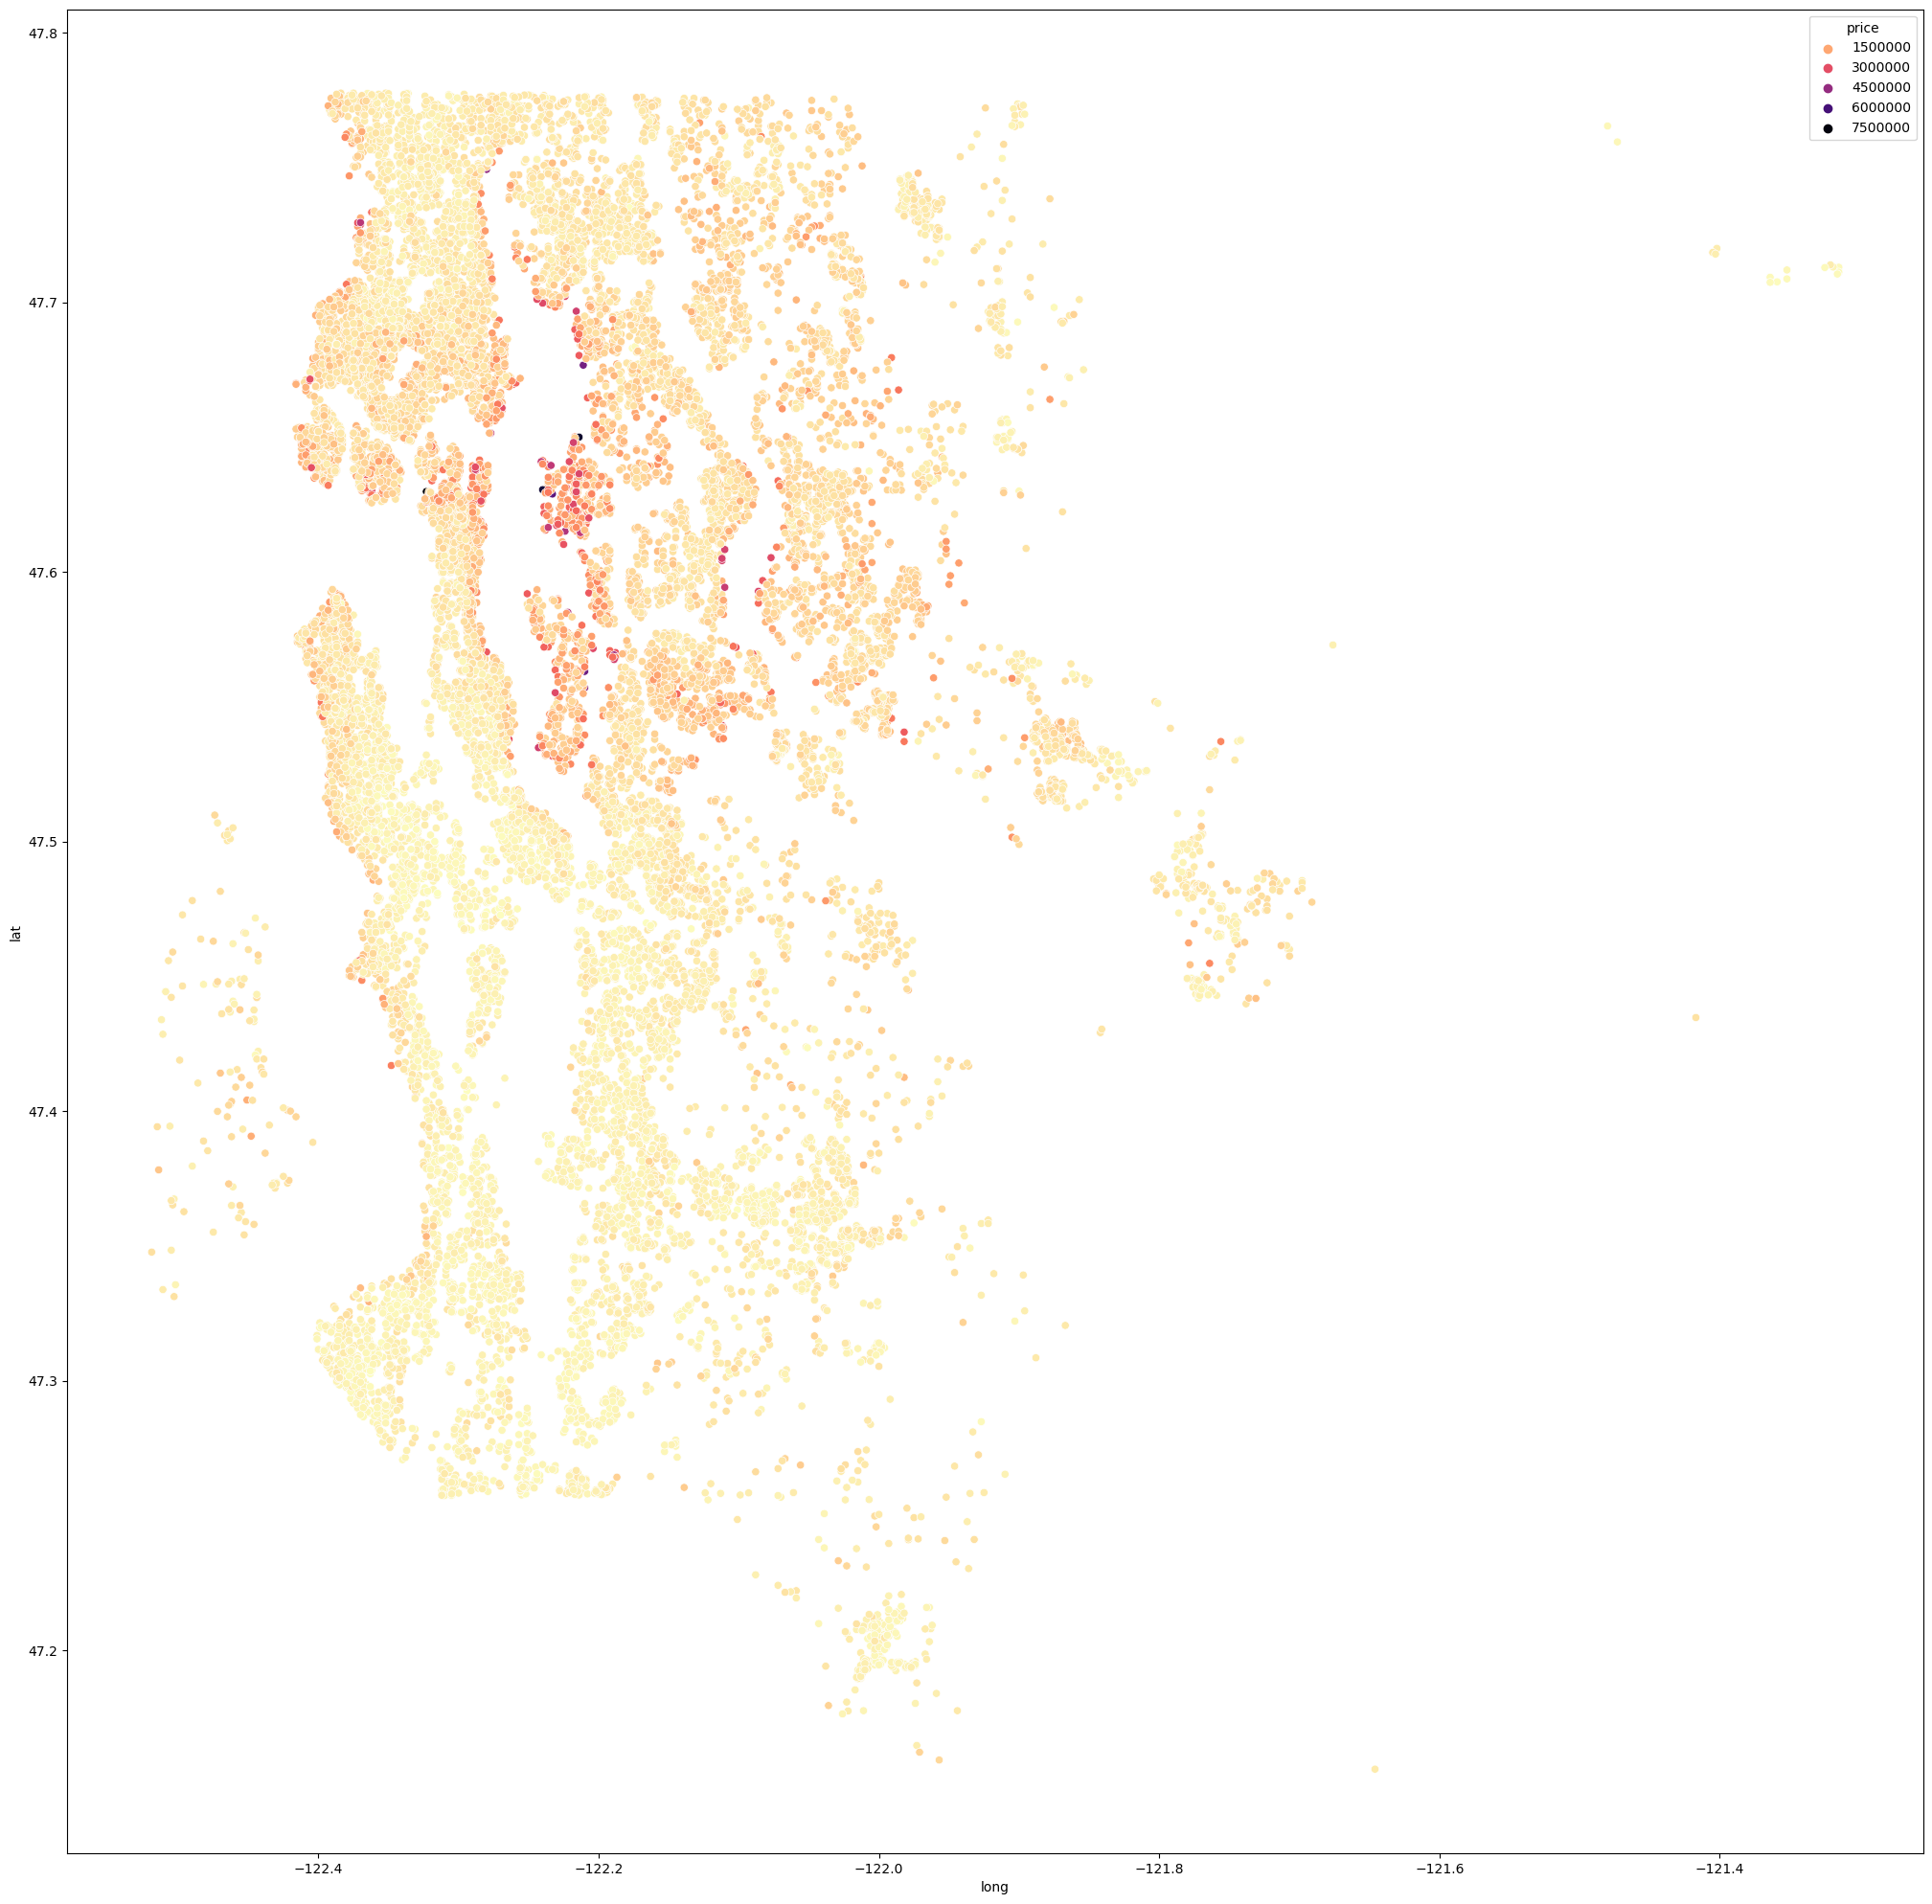

In [5]:
#looking at the plot below vs Seattle on google maps, the highest number of high sales are concentrated near CBD Seattle
#to focus on this significant area, outliers of high sales past long -122.0 will be deleted in attempt to help the model
#also to note the white areas around the high sale cluster are Lake Washington
#therefore this is showing waterfront could be significant

plt.figure(figsize=(25,25))
sns.scatterplot(data=data, x="long", y="lat", hue="price", palette="magma_r");

In [6]:
#drop outliers past long -122.0
data.drop(data[data['long'] >= -122.0].index, inplace=True)

In [7]:
#create column of lat & long for each property
data['coords'] = list(zip(data.lat, data.long))

#coordinates of Seattle Town Hall 
seattle=(47.60907,-122.32997)

#calculate the distance of the property from CBD Seattle then delete unnecessary columns
data['dist_seattle'] = data.apply(lambda x: geopy.distance.distance(seattle, x.coords).km, axis=1)
data = data.drop(['lat'], axis=1)
data = data.drop(['long'], axis=1)
data = data.drop(['coords'], axis=1)

In [8]:
#looking at correlation between variables and price from most positive to negatively correlated
#distance from seattle is negatively correlated, supporting view that closer to Seattle increases price
data.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702449
grade            0.665927
sqft_above       0.605390
sqft_living15    0.586604
bathrooms        0.521059
view             0.401020
sqft_basement    0.327411
bedrooms         0.301011
waterfront       0.268810
floors           0.251271
sqft_lot15       0.081752
sqft_lot         0.081710
condition        0.044671
dist_seattle    -0.315077
Name: price, dtype: float64

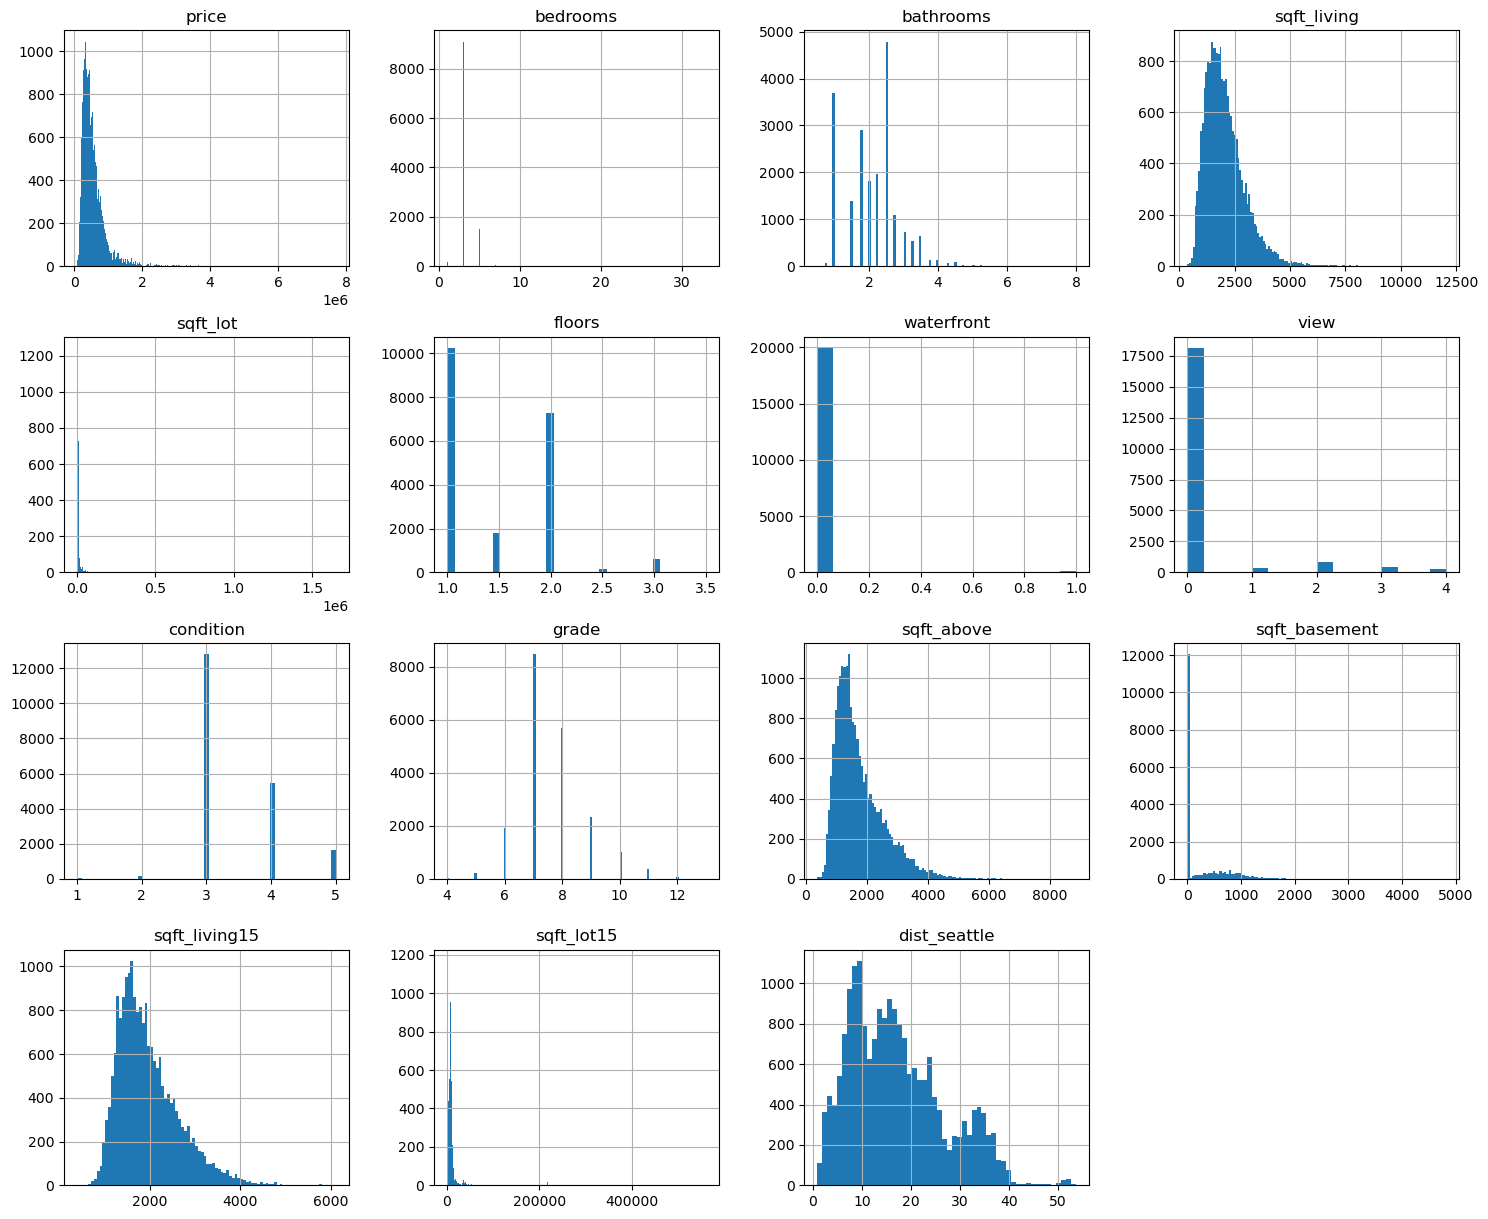

In [9]:
#looking at the shape of the data with histograms
#price and other continuous variables are all right skewed
#categorical variables are too numerous and will have to be reduced with dummies
data.hist(figsize=(18,15), bins='auto');

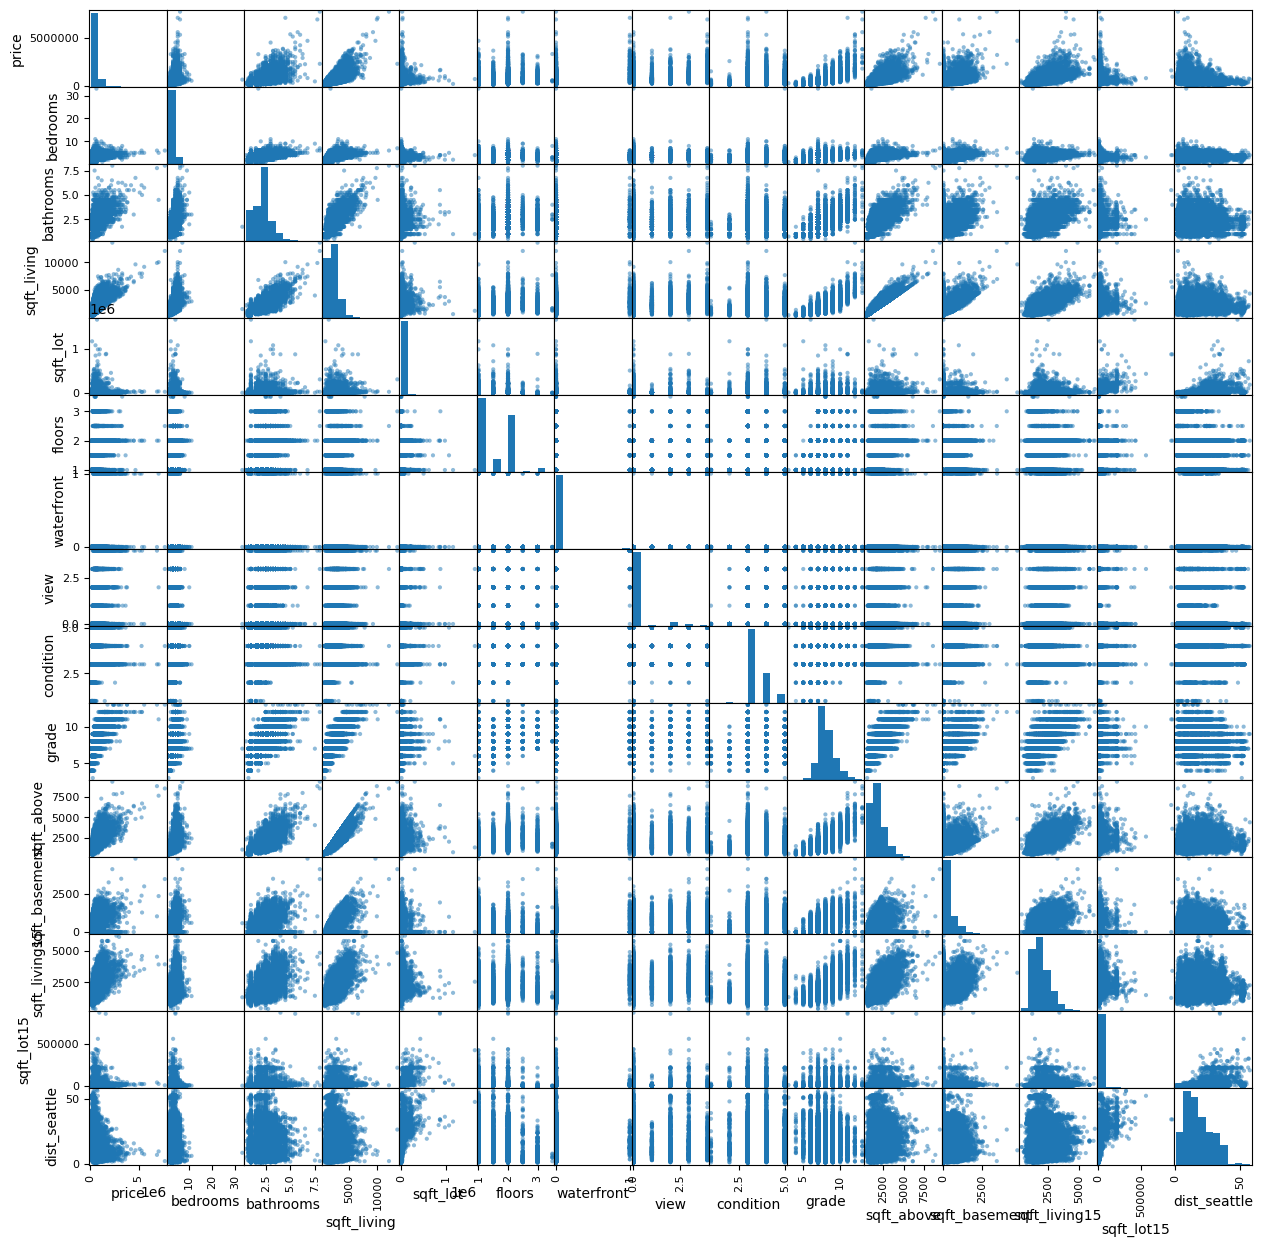

In [18]:
#looking for continuous & categorical variables in relation to price
pd.plotting.scatter_matrix(data,figsize=(15,15));

In [10]:
#look for outliers and spread of variables
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,dist_seattle
count,2.010100e+04,20101.000000,20101.000000,20101.000000,2.010100e+04,20101.000000,20101.000000,20101.000000,20101.000000,20101.000000,20101.000000,20101.000000,20101.000000,20101.000000,20101.000000
mean,5.418115e+05,3.371176,2.098154,2057.672156,1.270092e+04,1.480001,0.007263,0.234118,3.426397,7.640665,1754.549425,297.033282,1965.888613,10920.631660,17.143160
std,3.740266e+05,0.935472,0.765770,902.992051,3.128913e+04,0.542496,0.084917,0.767766,0.657462,1.158347,804.535527,443.134350,670.993529,19571.401397,9.644674
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,370.000000,0.000000,399.000000,651.000000,0.901403
25%,3.200000e+05,3.000000,1.500000,1410.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1180.000000,0.000000,1480.000000,5050.000000,9.360898
50%,4.500000e+05,3.000000,2.250000,1900.000000,7.517000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1540.000000,0.000000,1820.000000,7560.000000,15.624852
75%,6.450000e+05,4.000000,2.500000,2519.000000,1.030000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2153.000000,580.000000,2330.000000,9856.000000,23.166340
max,7.700000e+06,33.000000,8.000000,12050.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8860.000000,4820.000000,6110.000000,560617.000000,53.675126


In [11]:
#Missing data check
data.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
sqft_living15    0
sqft_lot15       0
dist_seattle     0
dtype: int64

In [12]:
#looking at sqft_basement
data['sqft_basement'].value_counts()

sqft_basement
0       12032
600       211
700       208
500       203
800       199
        ...  
2196        1
652         1
2500        1
415         1
248         1
Name: count, Length: 299, dtype: int64

In [13]:
#sqft_basement contains 12,032 of 0 - change this variable into a binary - 0 for no basement, 1 for basement
data.loc[data['sqft_basement'] > 0, 'sqft_basement'] = 1
data = data.rename(columns={'sqft_basement': 'basement'})
data['basement'].value_counts()

basement
0    12032
1     8069
Name: count, dtype: int64

# Outliers in categorical variables

In [14]:
#there is a very small number of homes with large number of bedrooms (either error or actual)
#drop outliers outside 3 stand devs to help the model

mean = data['bedrooms'].mean()
std = data['bedrooms'].std()

upper = mean + 3*std
lower = mean - 3*std

data.drop(data[(data.bedrooms >upper) | (data.bedrooms < lower) ].index, inplace=True)
data['bedrooms'].value_counts()

bedrooms
3    9102
4    6337
2    2652
5    1509
6     266
1     174
Name: count, dtype: int64

In [15]:
#categorise bathrooms to whole numbers 
def categorise_bathrooms(x):
    if x <2:
        return 1
    elif x < 3:
        return 2
    elif x < 4:
        return 3
    elif x < 5:
        return 4
    elif x < 6:
        return 5
    else:
        return 6
    
data['bathrooms'] = data['bathrooms'].apply(categorise_bathrooms)
print(data['bathrooms'].value_counts())

bathrooms
2    9637
1    8051
3    2015
4     289
5      38
6      10
Name: count, dtype: int64


In [16]:
#categorise floors to whole numbers to reduce no of categories in new column

def categorise_floors(x):
    if x <2:
        return 1
    elif x < 3:
        return 2
    else:
        return 3

data['floors'] = data['floors'].apply(categorise_floors)
print(data['floors'].value_counts())

#currently large number of grades, reduce number of dummy variables. 
def categorise_grade(x):
    if x <=4:
        return 4
    elif x <= 6:
        return 6
    elif x <= 8:
        return 8
    elif x <= 10:
        return 10
    else:
        return 13
    
#to reduce number of grades, as there are very few under 5, group these as 5
#also very few over 10 so group these high ones in 10
#this also keeps variable to manageable number of items
data.loc[data['grade'] >= 10, 'grade'] = 10
data.loc[data['grade'] <= 5, 'grade'] = 5
print(data['grade'].value_counts())

floors
1    12025
2     7403
3      612
Name: count, dtype: int64
grade
7     8450
8     5666
9     2327
6     1915
10    1449
5      233
Name: count, dtype: int64


In [17]:
#Cleaned dataset below of 14 independant variables and 20,040 rows
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20040 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20040 non-null  int32  
 1   bedrooms       20040 non-null  int64  
 2   bathrooms      20040 non-null  int64  
 3   sqft_living    20040 non-null  int64  
 4   sqft_lot       20040 non-null  int64  
 5   floors         20040 non-null  int64  
 6   waterfront     20040 non-null  int32  
 7   view           20040 non-null  int32  
 8   condition      20040 non-null  int64  
 9   grade          20040 non-null  int64  
 10  sqft_above     20040 non-null  int64  
 11  basement       20040 non-null  int32  
 12  sqft_living15  20040 non-null  int64  
 13  sqft_lot15     20040 non-null  int64  
 14  dist_seattle   20040 non-null  float64
dtypes: float64(1), int32(4), int64(10)
memory usage: 2.1 MB


# Dummy implementation

In [18]:
#dummy implementation on categorical variables
flrs_dummies = pd.get_dummies(data['floors'], prefix='flr', drop_first=True, dtype=int)
bed_dummies = pd.get_dummies(data['bedrooms'], prefix='bed', drop_first=True, dtype=int)
bath_dummies = pd.get_dummies(data['bathrooms'], prefix='bath', drop_first=True, dtype=int)
cond_dummies = pd.get_dummies(data['condition'], prefix='cond', drop_first=True, dtype=int)
grd_dummies = pd.get_dummies(data['grade'], prefix='grd', drop_first=True, dtype=int)
view_dummies = pd.get_dummies(data['view'], prefix='view', drop_first=True, dtype=int)
wtf_dummies = pd.get_dummies(data['waterfront'], prefix='wtf', drop_first=True, dtype=int)
bmst_dummies = pd.get_dummies(data['basement'], prefix='bsmt', drop_first=True, dtype=int)

data = data.drop(['floors', 'bedrooms', 'bathrooms','condition', 'grade', 'waterfront', 'view', 'basement'], axis=1)
data = pd.concat([data, flrs_dummies, bed_dummies, bath_dummies, cond_dummies, grd_dummies, view_dummies, wtf_dummies, bmst_dummies], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20040 entries, 0 to 21596
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20040 non-null  int32  
 1   sqft_living    20040 non-null  int64  
 2   sqft_lot       20040 non-null  int64  
 3   sqft_above     20040 non-null  int64  
 4   sqft_living15  20040 non-null  int64  
 5   sqft_lot15     20040 non-null  int64  
 6   dist_seattle   20040 non-null  float64
 7   flr_2          20040 non-null  int32  
 8   flr_3          20040 non-null  int32  
 9   bed_2          20040 non-null  int32  
 10  bed_3          20040 non-null  int32  
 11  bed_4          20040 non-null  int32  
 12  bed_5          20040 non-null  int32  
 13  bed_6          20040 non-null  int32  
 14  bath_2         20040 non-null  int32  
 15  bath_3         20040 non-null  int32  
 16  bath_4         20040 non-null  int32  
 17  bath_5         20040 non-null  int32  
 18  bath_6     

# Model 1

In [19]:
outcome = 'price'
x_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'dist_seattle', 'flr_2','flr_3','bed_2','bed_3','bed_4','bed_5','bed_6','bath_2','bath_3','bath_4', 'bath_5', 'bath_6', 'cond_2','cond_3', 'cond_4','cond_5','grd_6','grd_7','grd_8', 'grd_9', 'grd_10', 'view_1','view_2','view_3','view_4', 'wtf_1', 'bsmt_1']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     1757.
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:14:15   Log-Likelihood:            -2.7185e+05
No. Observations:               20040   AIC:                         5.438e+05
Df Residuals:                   20006   BIC:                         5.440e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.745e+04   3.86e+04      2.522      0.012    2.17e+04    1.73e+05
sqft_living     130.8599      5.879     22.258      0.000     119.336     142.384
sqft_lot          0.2121      0.061      3.487      0.000       0.093       0.331
sqft_above       52.9503      6.518      8.124      0.000      40.175      65.726
sqft_living15    68.5237      3.383     20.254      0.000      61.892      75.155
sqft_lot15        0.0455      0.099      0.460      0.646      -0.148       0.239
dist_seattle   -1.36e+04    159.209    -85.397      0.000   -1.39e+04   -1.33e+04
flr_2         -3.726e+04   4086.952     -9.117      0.000   -4.53e+04   -2.92e+04
flr_3         -5.085e+04   8749.468     -5.811      0.000    -6.8e+04   -3.37e+04
bed_2          2.077e+04    1.5e+04      1.384      0.166   -8653.782    5.02e+04
bed_3          1.022e+04    1.5e+04      0.682      0.496   -1.92e+04    3.96e+04
bed_4         -2.123e+04   1.53e+04     -1.387      0.165   -5.12e+04    8768.306
bed_5         -4.487e+04   1.61e+04     -2.789      0.005   -7.64e+04   -1.33e+04
bed_6         -1.076e+05   1.94e+04     -5.545      0.000   -1.46e+05   -6.96e+04
bath_2        -2802.1457   3759.523     -0.745      0.456   -1.02e+04    4566.830
bath_3         4.613e+04   6292.171      7.332      0.000    3.38e+04    5.85e+04
bath_4         2.096e+05   1.33e+04     15.783      0.000    1.84e+05    2.36e+05
bath_5         7.023e+05   3.22e+04     21.829      0.000    6.39e+05    7.65e+05
bath_6          1.91e+06   6.21e+04     30.751      0.000    1.79e+06    2.03e+06
cond_2         6.505e+04   3.89e+04      1.672      0.095   -1.12e+04    1.41e+05
cond_3         7.837e+04    3.6e+04      2.174      0.030    7725.150    1.49e+05
cond_4         1.287e+05   3.61e+04      3.567      0.000     5.8e+04    1.99e+05
cond_5         1.663e+05   3.63e+04      4.584      0.000    9.52e+04    2.37e+05
grd_6         -8435.1008   1.34e+04     -0.631      0.528   -3.46e+04    1.78e+04
grd_7          3.615e+04   1.31e+04      2.752      0.006    1.04e+04    6.19e+04
grd_8          7.889e+04   1.36e+04      5.809      0.000    5.23e+04    1.06e+05
grd_9          1.554e+05   1.45e+04     10.727      0.000    1.27e+05    1.84e+05
grd_10         3.382e+05   1.58e+04     21.394      0.000    3.07e+05    3.69e+05
view_1         8.012e+04   1.07e+04      7.516      0.000    5.92e+04    1.01e+05
view_2         5.577e+04   6762.511      8.247      0.000    4.25e+04     6.9e+04
view_3         1.228e+05   9176.921     13.382      0.000    1.05e+05    1.41e+05
view_4         2.795e+05   1.36e+04     20.509      0.000    2.53e+05    3.06e+05
wtf_1          5.263e+05   1.93e+04     27.300      0.000    4.89e+05    5.64e+05
bsmt_1        -1.221e+04   4913.123     -2.486      0.013   -2.18e+04   -2581.650
=================================================

In [20]:
#check for multicollinerarity

df=data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)
df.columns = ['cc']
df.drop_duplicates(inplace=True)
df[(df.cc>.75) & (df.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.869369
"(cond_3, cond_4)",0.810070
"(sqft_living, sqft_living15)",0.752142


In [21]:
# drop 1 variable from each pair showing multicollinerarity above
#also drop variables which are not significant at more than 0.05 p value
data = data.drop(['sqft_above'], axis=1)
data = data.drop(['cond_3'], axis=1)
data = data.drop(['sqft_living15'], axis=1)
data = data.drop(['sqft_lot15'], axis=1)
data = data.drop(['bed_2'], axis=1)
data = data.drop(['bed_3'], axis=1)
data = data.drop(['bed_4'], axis=1)
data = data.drop(['bath_2'], axis=1)
data = data.drop(['cond_2'], axis=1)
data = data.drop(['grd_6'], axis=1)

In [22]:
#recheck for multicollinerarity

df=data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)
df.columns = ['cc']

df.drop_duplicates(inplace=True)
df[(df.cc>.75) & (df.cc <1)]

,cc
pairs,


# Model 2

In [23]:
outcome = 'price'
x_cols = ['sqft_living', 'sqft_lot', 'dist_seattle', 'flr_2', 'flr_3','bed_5','bed_6','bath_3','bath_4', 'bath_5', 'bath_6', 'cond_4','cond_5','grd_7','grd_8', 'grd_9', 'grd_10', 'view_1','view_2','view_3','view_4', 'wtf_1','bsmt_1']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     2422.
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:14:46   Log-Likelihood:            -2.7215e+05
No. Observations:               20040   AIC:                         5.443e+05
Df Residuals:                   20016   BIC:                         5.445e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.662e+05   5620.687     47.355      0.000    2.55e+05    2.77e+05
sqft_living    186.5119      2.838     65.711      0.000     180.948     192.075
sqft_lot         0.2917      0.045      6.458      0.000       0.203       0.380
dist_seattle  -1.33e+04    155.926    -85.277      0.000   -1.36e+04    -1.3e+04
flr_2        -3.174e+04   3705.758     -8.564      0.000    -3.9e+04   -2.45e+04
flr_3        -6.697e+04   8571.002     -7.814      0.000   -8.38e+04   -5.02e+04
bed_5         -3.93e+04   5530.072     -7.107      0.000   -5.01e+04   -2.85e+04
bed_6         -1.13e+05   1.23e+04     -9.201      0.000   -1.37e+05    -8.9e+04
bath_3        4.115e+04   5233.239      7.862      0.000    3.09e+04    5.14e+04
bath_4        2.088e+05   1.27e+04     16.458      0.000    1.84e+05    2.34e+05
bath_5        6.932e+05   3.21e+04     21.562      0.000     6.3e+05    7.56e+05
bath_6        1.884e+06   6.23e+04     30.221      0.000    1.76e+06    2.01e+06
cond_4        4.911e+04   3249.666     15.113      0.000    4.27e+04    5.55e+04
cond_5        7.938e+04   5167.620     15.361      0.000    6.93e+04    8.95e+04
grd_7         5.195e+04   4867.910     10.672      0.000    4.24e+04    6.15e+04
grd_8         1.115e+05   5737.496     19.426      0.000       1e+05    1.23e+05
grd_9         2.107e+05   7417.412     28.409      0.000    1.96e+05    2.25e+05
grd_10        4.233e+05   9459.915     44.742      0.000    4.05e+05    4.42e+05
view_1        9.567e+04   1.08e+04      8.873      0.000    7.45e+04    1.17e+05
view_2        6.811e+04   6815.220      9.994      0.000    5.48e+04    8.15e+04
view_3        1.337e+05   9219.626     14.501      0.000    1.16e+05    1.52e+05
view_4        2.957e+05   1.38e+04     21.506      0.000    2.69e+05    3.23e+05
wtf_1         5.228e+05   1.95e+04     26.755      0.000    4.85e+05    5.61e+05
bsmt_1       -4.856e+04   3281.187    -14.800      0.000    -5.5e+04   -4.21e+04
==============================================================================
Omnibus:                    12548.040   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           858619.606
Skew:                           2.256   Prob(JB):                         0.00
Kurtosis:                      34.748   Cond. No.                     1.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

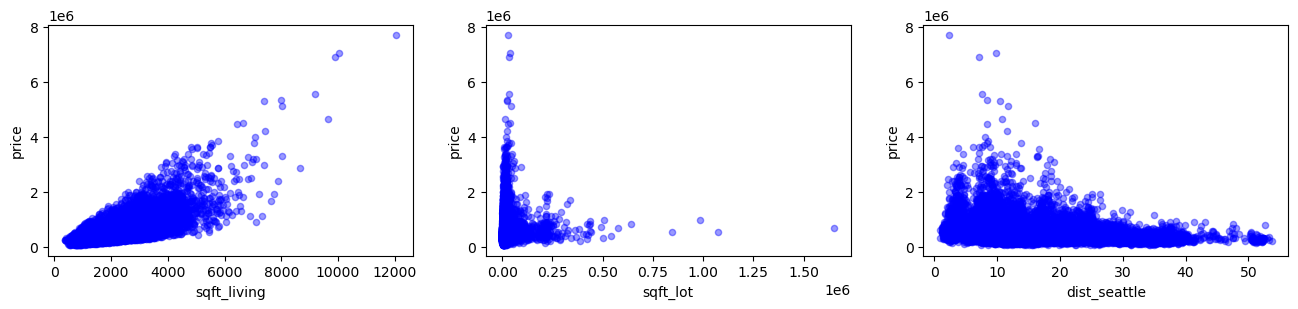

In [24]:
#check for linear relationship with price. 
#sqft_lot does not appear linear, will recheck following log transformation
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
for xcol, ax in zip([ 'sqft_living','sqft_lot', 'dist_seattle'], axes):
    data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

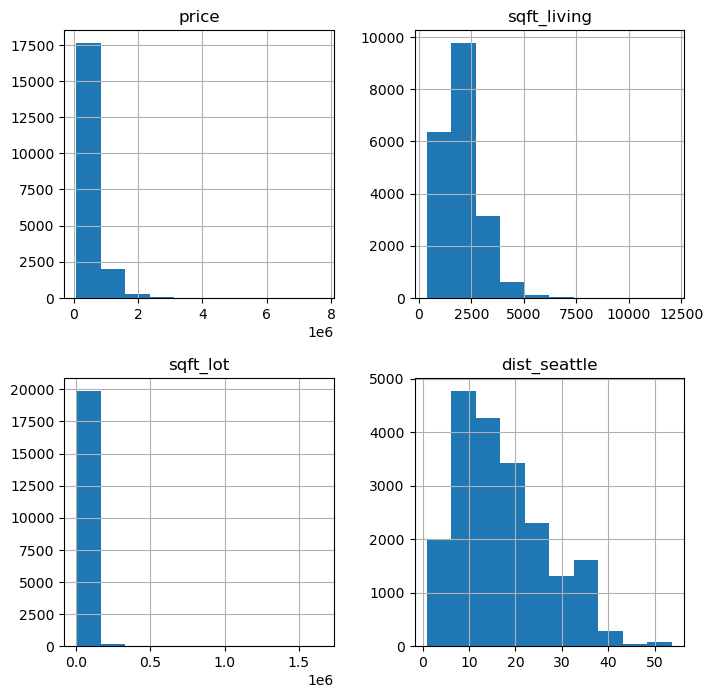

In [25]:
#check distribution of continuous variables
#these are right skewed and not normally distributed, these will be log transformed & standardised
data[['price', 'sqft_living', 'sqft_lot', 'dist_seattle' ]].hist(figsize  = [8, 8]); 

# Log transformations & scaling

In [26]:
#log transformations and scaling to normalise continuous variables

data['price'] = np.log(data['price'])
data['sqft_living'] = np.log(data['sqft_living'])
data['sqft_lot'] = np.log(data['sqft_lot'])
data['dist_seattle'] = np.log(data['dist_seattle'])

data[['price', 'sqft_living', 'sqft_lot', 'dist_seattle']] = StandardScaler().fit_transform(data[['price', 'sqft_living', 'sqft_lot', 'dist_seattle']])


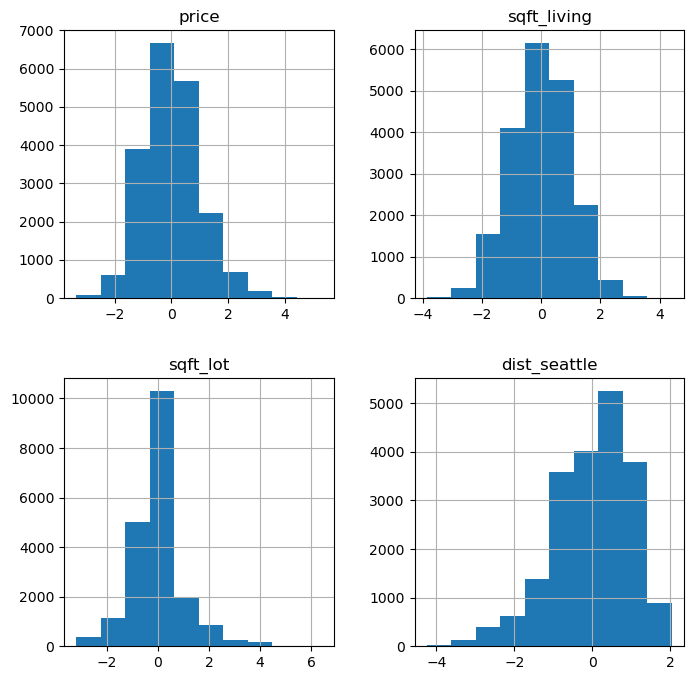

In [27]:
#variable distributions after log transformations
#these are now closer to being normally dictributed compared to original distributions
data[['price', 'sqft_living', 'sqft_lot', 'dist_seattle' ]].hist(figsize  = [8, 8]); 

In [28]:
#re-run model with log transformed variables to check linear regression assumptions
outcome = 'price'
x_cols = ['sqft_living', 'sqft_lot', 'dist_seattle', 'flr_2', 'flr_3','bed_5','bed_6','bath_3','bath_4', 'bath_5', 'bath_6', 'cond_4','cond_5','grd_7','grd_8', 'grd_9', 'grd_10', 'view_1','view_2','view_3','view_4', 'wtf_1','bsmt_1']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     2633.
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:16:50   Log-Likelihood:                -14480.
No. Observations:               20040   AIC:                         2.901e+04
Df Residuals:                   20016   BIC:                         2.920e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.5738      0.015    -38.474      0.000      -0.603      -0.545
sqft_living      0.4061      0.007     61.822      0.000       0.393       0.419
sqft_lot         0.1209      0.005     24.557      0.000       0.111       0.131
dist_seattle    -0.4798      0.004   -111.584      0.000      -0.488      -0.471
flr_2           -0.0387      0.010     -3.708      0.000      -0.059      -0.018
flr_3           -0.0635      0.024     -2.656      0.008      -0.110      -0.017
bed_5           -0.0626      0.014     -4.370      0.000      -0.091      -0.035
bed_6           -0.2129      0.032     -6.660      0.000      -0.276      -0.150
bath_3           0.0779      0.013      5.776      0.000       0.051       0.104
bath_4           0.2653      0.032      8.184      0.000       0.202       0.329
bath_5           0.6279      0.083      7.594      0.000       0.466       0.790
bath_6           0.9503      0.160      5.946      0.000       0.637       1.264
cond_4           0.1309      0.009     15.399      0.000       0.114       0.148
cond_5           0.2390      0.013     17.711      0.000       0.213       0.265
grd_7            0.3326      0.013     25.229      0.000       0.307       0.358
grd_8            0.6574      0.016     41.568      0.000       0.626       0.688
grd_9            1.0008      0.020     50.058      0.000       0.962       1.040
grd_10           1.3722      0.024     56.472      0.000       1.325       1.420
view_1           0.2656      0.028      9.458      0.000       0.211       0.321
view_2           0.1578      0.018      8.882      0.000       0.123       0.193
view_3           0.2692      0.024     11.217      0.000       0.222       0.316
view_4           0.5261      0.036     14.686      0.000       0.456       0.596
wtf_1            0.7617      0.051     14.944      0.000       0.662       0.862
bsmt_1          -0.1090      0.009    -12.231      0.000      -0.127      -0.092
==============================================================================
Omnibus:                      278.482   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.053
Skew:                          -0.167   Prob(JB):                     3.01e-88
Kurtosis:                       3.610   Cond. No.                         60.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

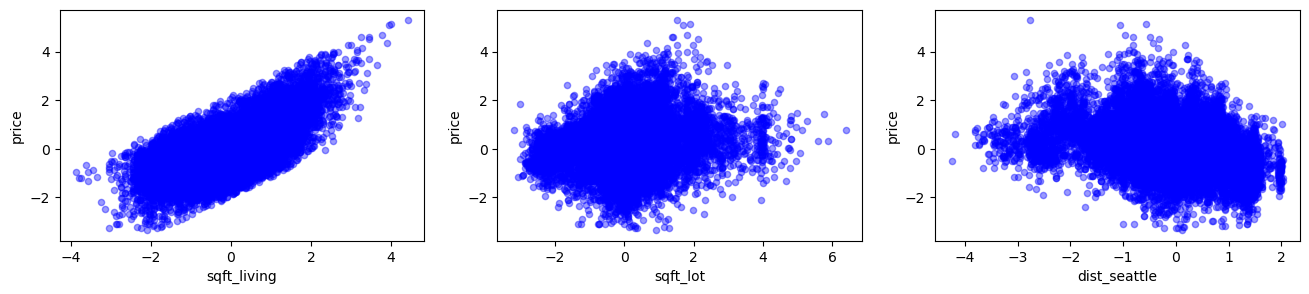

In [29]:
#rechecking linearity of continuous variables after log transformations
#sqft_living has a strong linear relationship with price
#sqft_lot & dist_seattle have weak linear relationships with price

%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
for xcol, ax in zip([ 'sqft_living','sqft_lot', 'dist_seattle'], axes):
    data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

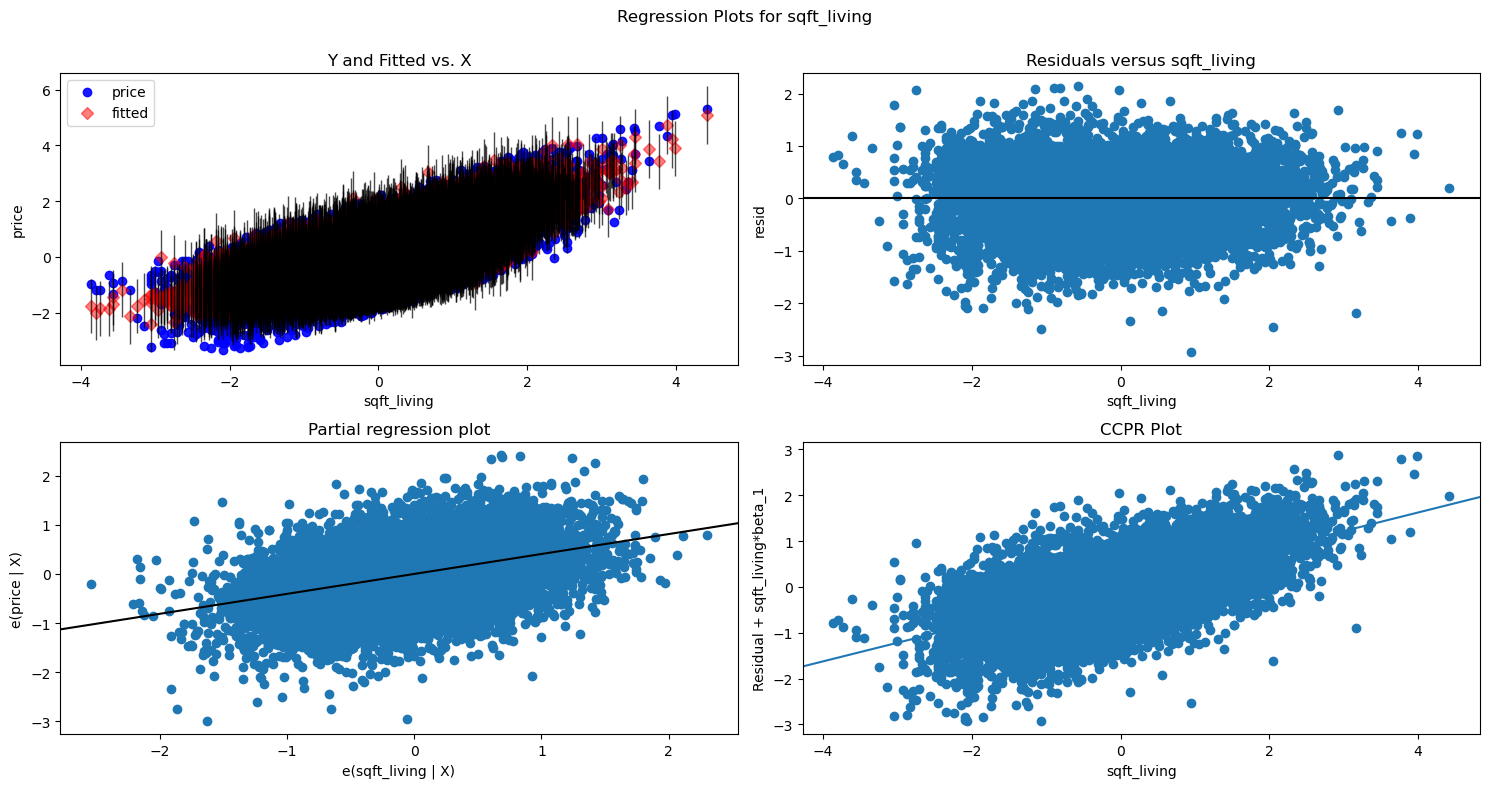

In [30]:
#checking sqft_living for homoscedasticity 
# the residual variability is equal across values of the independent variable.
#therefore sqft_living meets homoscedasticity assumption

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

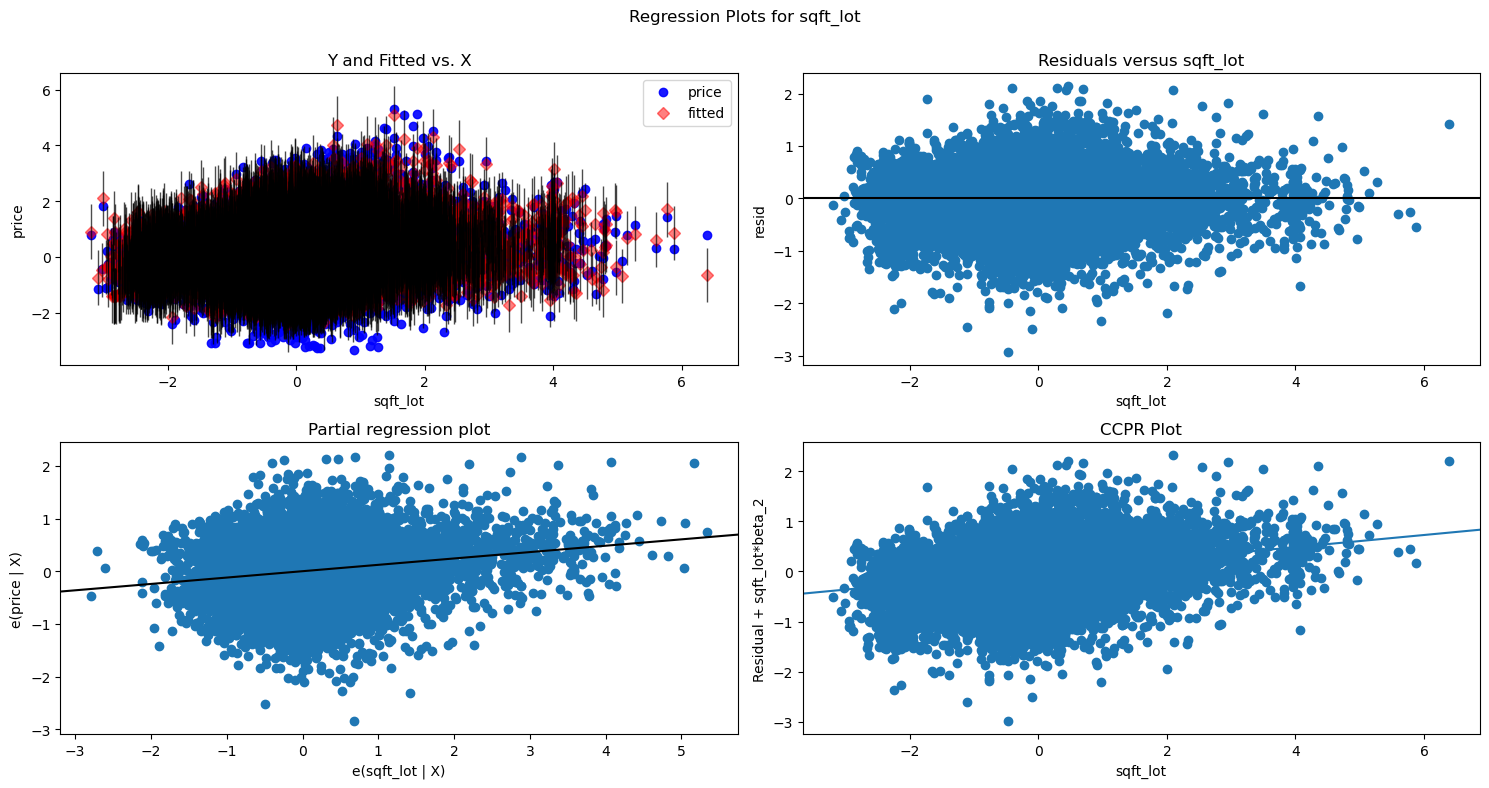

In [31]:
#checking sqft_lot for homoscedasticity 
# the residual variability is equal across values of the independent variable.
#therefore sqft_lot meets homoscedasticity assumption

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_lot", fig=fig)
plt.show()

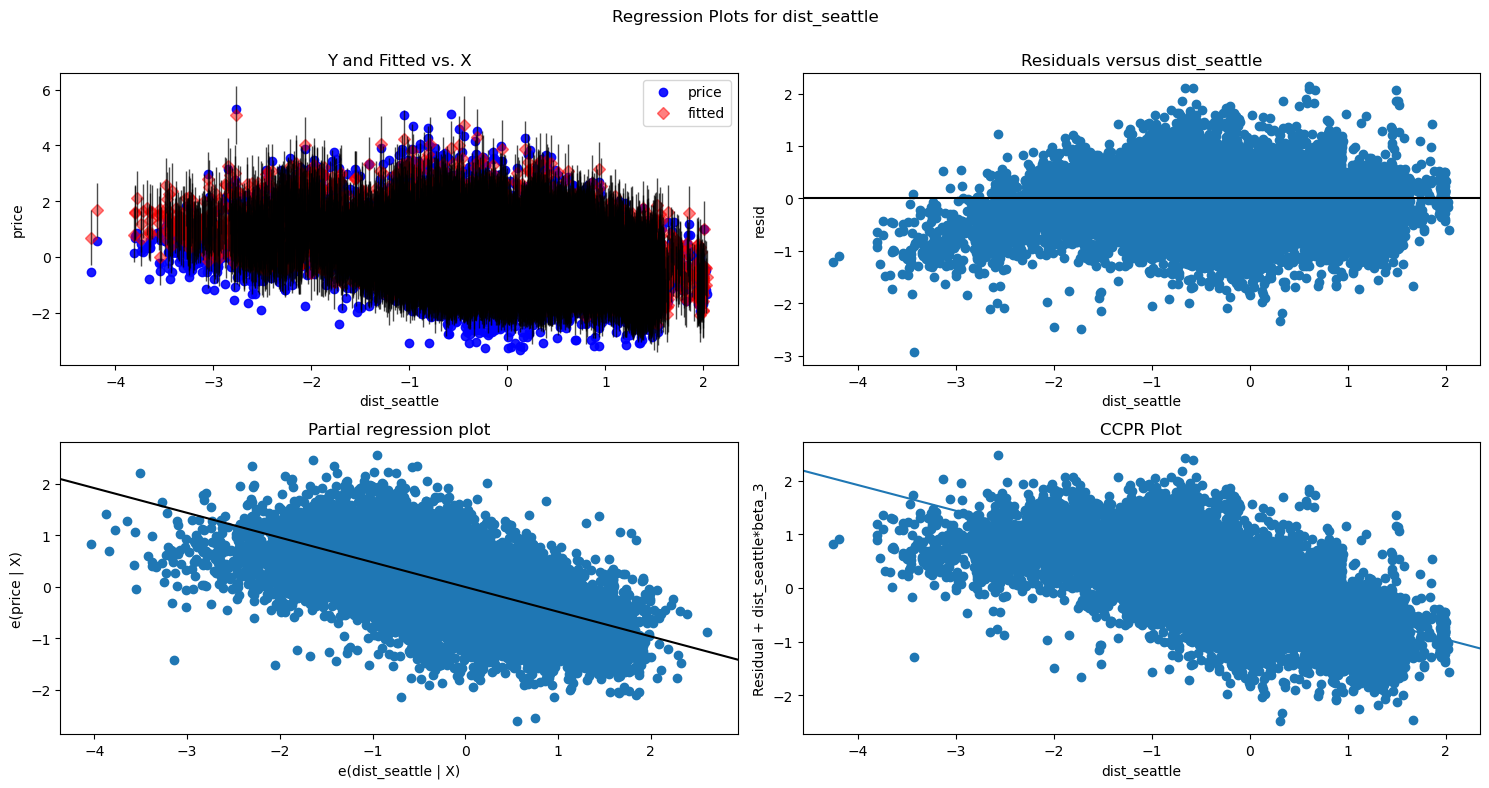

In [32]:
#checking dist_seattle for homoscedasticity 
# the residual variability is equal across values of the independent variable.
#therefore dist_seattle meets homoscedasticity assumption

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "dist_seattle", fig=fig)
plt.show()

C:\Users\bridg\AppData\Local\Temp\ipykernel_2844\2992656137.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


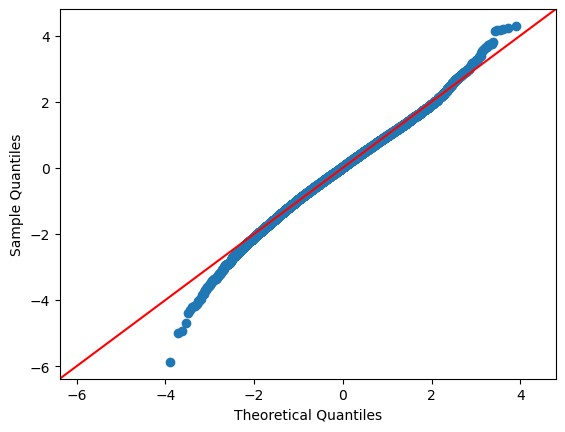

In [35]:
#use Q-Q plot to check normality of dataset
#below shows most of the dataset is on the line, with high & low outliers off the line
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

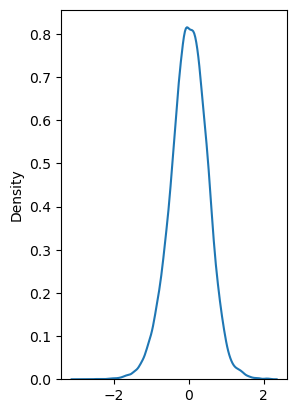

In [37]:
#checking for normal distribution of model residuals

ax2 = plt.subplot(122)
sns.kdeplot(residuals, ax=ax2)
plt.show()

# Assumptions

Once log transformed, the continuous variables have met the assumptions of linearity and homoscedasticity and are normally distributed.
Therefore these variables meet the assumptions for linear regression and will be kept for the final model.

# Final Model 

In [34]:
outcome = 'price'
x_cols = ['sqft_living', 'sqft_lot', 'bsmt_1', 'dist_seattle', 'flr_2','flr_3','bed_5','bed_6','bath_3','bath_4', 'bath_5', 'bath_6', 'cond_4','cond_5','grd_7','grd_8', 'grd_9', 'grd_10', 'view_1','view_2','view_3','view_4', 'wtf_1']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     2633.
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:20:11   Log-Likelihood:                -14480.
No. Observations:               20040   AIC:                         2.901e+04
Df Residuals:                   20016   BIC:                         2.920e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.5738      0.015    -38.474      0.000      -0.603      -0.545
sqft_living      0.4061      0.007     61.822      0.000       0.393       0.419
sqft_lot         0.1209      0.005     24.557      0.000       0.111       0.131
bsmt_1          -0.1090      0.009    -12.231      0.000      -0.127      -0.092
dist_seattle    -0.4798      0.004   -111.584      0.000      -0.488      -0.471
flr_2           -0.0387      0.010     -3.708      0.000      -0.059      -0.018
flr_3           -0.0635      0.024     -2.656      0.008      -0.110      -0.017
bed_5           -0.0626      0.014     -4.370      0.000      -0.091      -0.035
bed_6           -0.2129      0.032     -6.660      0.000      -0.276      -0.150
bath_3           0.0779      0.013      5.776      0.000       0.051       0.104
bath_4           0.2653      0.032      8.184      0.000       0.202       0.329
bath_5           0.6279      0.083      7.594      0.000       0.466       0.790
bath_6           0.9503      0.160      5.946      0.000       0.637       1.264
cond_4           0.1309      0.009     15.399      0.000       0.114       0.148
cond_5           0.2390      0.013     17.711      0.000       0.213       0.265
grd_7            0.3326      0.013     25.229      0.000       0.307       0.358
grd_8            0.6574      0.016     41.568      0.000       0.626       0.688
grd_9            1.0008      0.020     50.058      0.000       0.962       1.040
grd_10           1.3722      0.024     56.472      0.000       1.325       1.420
view_1           0.2656      0.028      9.458      0.000       0.211       0.321
view_2           0.1578      0.018      8.882      0.000       0.123       0.193
view_3           0.2692      0.024     11.217      0.000       0.222       0.316
view_4           0.5261      0.036     14.686      0.000       0.456       0.596
wtf_1            0.7617      0.051     14.944      0.000       0.662       0.862
==============================================================================
Omnibus:                      278.482   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.053
Skew:                          -0.167   Prob(JB):                     3.01e-88
Kurtosis:                       3.610   Cond. No.                         60.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model validation

In [38]:
train, test = train_test_split(data)

In [39]:
y = data[['price']]
X = data.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

16032 4008 16032 4008


In [42]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [43]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [44]:
mse_train = np.sum((y_train - y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test - y_hat_test)**2)/len(y_test)
print('Train Mean Squared Error:', mse_train)
print('Test Mean Squared Error:', mse_test)

Train Mean Squared Error: price    0.24794
dtype: float64
Test Mean Squared Error: price    0.250647
dtype: float64


As above, the train & test mean squared error are close enough that the model is valid

# Interpreting the Final Model

The final model has an adjusted R^2 of 0.751 which means that the model explains or predicts 75.1% of the relationship between house sale price and the independent variables.

# Interpreting at the coefficients for continuous variables - 

1/Square feet of living space increased sale price - a 1% increase in square feet of living space would increase the sale price by 0.46%

(As both the dependent and independent variables were log-transformed, we interpret the coefficients as the percent increase in the dependent variable for every 1% increase in the independent variable. e.g. the coefficient is 0.198. For every 1% increase in the independent variable, our dependent variable increases by about 0.20%.** )

2/The distance from Seattle reduces the sale price of the house, shown by the negative coefficient. This was in line with the initial mapping of the home sales showing the high sale cluster near Seattle.


# Interpreting at the coefficients for the categorical variables - 

3/With negative coefficients, having a basement, the number of floors and the number of bedrooms in the home does not positively impact sale price.

4/The number of bathrooms does positively impact sale price for 3 or more bathrooms, adding more value as the number of bathrooms increases.

5/The condition does positively impact the price for level 4 ("Good") and 5 ("Very Good")

6/The construction and design increases the sale price, for Grade 7 (Average) and above, up to Grade 10 (High). As the grade of the house increases, so does the effect on increasing the sale price. Grade 10 construction has the highest positive coefficient of the model.

7/Having a view increases the sale price, and the better the view, the more the sale price increases.

8/Being on the waterfront greatly increases the sale price of the house, having a high positive coefficient of 0.7274. This is confirming the map above where the cluster of homes near Seattle CBD are also on the waterfront of Lake Washington.

From the above outcomes, we can reject the null hypothesis that there are no variables that increase house sale prices.

# Recommendations

The house flipping business venture should focus on the factors which would lead to the biggest increase in sale price, being the variables with the highest positive coefficients -  

1/The construction Grade 9 and Grade 10 (being the highest) have the highest positive coefficients - therefore focus on houses with very high construction quality and ensure all renovations are done to the highest quality possible. The higher the quality, the higher the price. 

2/Other highly positive coefficients are square feet of living space, having more than 5 bathrooms, waterfront or views - therefore look for houses with these or which can be renovated to add these to the property to increase the sale price.

3/The most negatively significant variable was distance from Seattle. Therefore is it recommended to find properties which are close to Seattle CBD to maximise the sale price.

In summary, based on the model, homes build to a high quality, near Seattle on the waterfront or with views are most likely to sell for a higher price.


Sources
** https://library.virginia.edu/data/articles/interpreting-log-transformations-in-a-linear-model